In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torchvision import models
import torchvision.utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Define data transformations (resize, crop, normalize)
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(299),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), # ToTensor : [0, 255] -> [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(), # ToTensor : [0, 255] -> [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [5]:
!unzip /content/drive/MyDrive/Output.zip -d /content/drive/MyDrive/

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/Output/train/Dog/6421.jpg  
  inflating: /content/drive/MyDrive/Output/train/Dog/42.jpg  
  inflating: /content/drive/MyDrive/Output/train/Dog/802.jpg  
  inflating: /content/drive/MyDrive/Output/train/Dog/1428.jpg  
  inflating: /content/drive/MyDrive/Output/train/Dog/9074.jpg  
  inflating: /content/drive/MyDrive/Output/train/Dog/10466.jpg  
  inflating: /content/drive/MyDrive/Output/train/Dog/2121.jpg  
  inflating: /content/drive/MyDrive/Output/train/Dog/11778.jpg  
  inflating: /content/drive/MyDrive/Output/train/Dog/4550.jpg  
  inflating: /content/drive/MyDrive/Output/train/Dog/10472.jpg  
  inflating: /content/drive/MyDrive/Output/train/Dog/2135.jpg  
  inflating: /content/drive/MyDrive/Output/train/Dog/4.jpg  
  inflating: /content/drive/MyDrive/Output/train/Dog/5882.jpg  
  inflating: /content/drive/MyDrive/Output/train/Dog/4544.jpg  
  inflating: /content/drive/MyDrive/Output/train/Dog/122

In [6]:
train_data = dsets.ImageFolder('/content/drive/MyDrive/Output/train', train_transform)
test_data = dsets.ImageFolder('/content/drive/MyDrive/Output/val', test_transform)
val_data = dsets.ImageFolder('/content/drive/MyDrive/Output/test', test_transform)

In [7]:
batch_size = 30

train_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(test_data,
                         batch_size=batch_size,
                         shuffle=True)

# Assuming you have a validation dataset named 'val_data' and batch_size_val
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)

In [8]:
def imshow(img, title):
    img = torchvision.utils.make_grid(img, normalize=True)
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

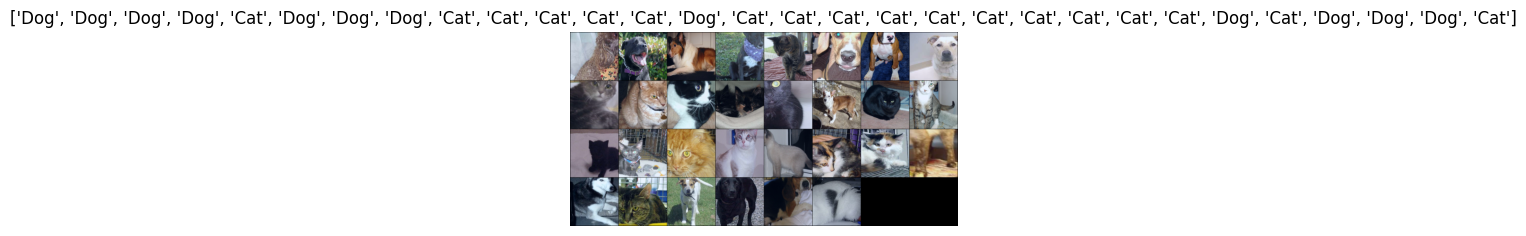

In [9]:
dataiter = iter(train_loader)
images, labels = dataiter.__next__()

imshow(images, [train_data.classes[i] for i in labels])

In [10]:
model = models.inception_v3(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 158MB/s] 


In [11]:
model.aux_logits = False

for parameter in model.parameters():
    parameter.requires_grad = False

In [12]:
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 10),
    nn.Linear(10, 2)
)

In [13]:
model = model.cuda()

In [14]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

Model Training

In [15]:
num_epochs = 5

In [16]:
import time
import torch.nn.functional as F
import time

In [23]:
def train_one_epoch(model, train_loader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        images = F.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

        if (i + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Iter [{i+1}/{len(train_loader)}] Training Loss: {loss.item():.4f}')

    avg_loss = total_loss / len(train_loader)
    accuracy = 100 * total_correct / total_samples
    return avg_loss, accuracy

def validate_model(model, val_loader, loss_fn, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            images = F.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)

            outputs = model(images)
            loss = loss_fn(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(val_loader)
    accuracy = 100 * total_correct / total_samples
    return avg_loss, accuracy

# Main training and validation loop
best_val_acc = 0.0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    start_time = time.time()

    train_loss, train_accuracy = train_one_epoch(model, train_loader, optimizer, loss, device)
    val_loss, val_accuracy = validate_model(model, val_loader, loss, device)

    epoch_time = time.time() - start_time

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%, Time: {epoch_time:.2f}s')

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        # Save your model using torch.save if needed

print('Training complete!')



Epoch [1/5], Iter [5/667] Training Loss: 0.0944
Epoch [1/5], Iter [10/667] Training Loss: 0.1174
Epoch [1/5], Iter [15/667] Training Loss: 0.1158
Epoch [1/5], Iter [20/667] Training Loss: 0.2192
Epoch [1/5], Iter [25/667] Training Loss: 0.0920
Epoch [1/5], Iter [30/667] Training Loss: 0.0865
Epoch [1/5], Iter [35/667] Training Loss: 0.1594
Epoch [1/5], Iter [40/667] Training Loss: 0.0697
Epoch [1/5], Iter [45/667] Training Loss: 0.4647
Epoch [1/5], Iter [50/667] Training Loss: 0.1217
Epoch [1/5], Iter [55/667] Training Loss: 0.1351
Epoch [1/5], Iter [60/667] Training Loss: 0.1359
Epoch [1/5], Iter [65/667] Training Loss: 0.1480
Epoch [1/5], Iter [70/667] Training Loss: 0.0480
Epoch [1/5], Iter [75/667] Training Loss: 0.1440
Epoch [1/5], Iter [80/667] Training Loss: 0.0794
Epoch [1/5], Iter [85/667] Training Loss: 0.2550
Epoch [1/5], Iter [90/667] Training Loss: 0.0556
Epoch [1/5], Iter [95/667] Training Loss: 0.4097
Epoch [1/5], Iter [100/667] Training Loss: 0.0760
Epoch [1/5], Iter [1

In [20]:
# Define the device (use GPU if available, otherwise use CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)  # Move the model to the specified device

model.eval()

correct = 0
total = 0

with torch.no_grad():  # Use no_grad to avoid computing gradients during evaluation
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)  # Transfer data to the GPU or CPU based on device

        outputs = model(images)

        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()  # Use .item() to get a scalar value

accuracy = 100 * correct / total
print('Accuracy of test images: %.2f%%' % accuracy)


Accuracy of test images: 98.32%


Predicted:    Cat   Cat   Dog   Cat   Cat


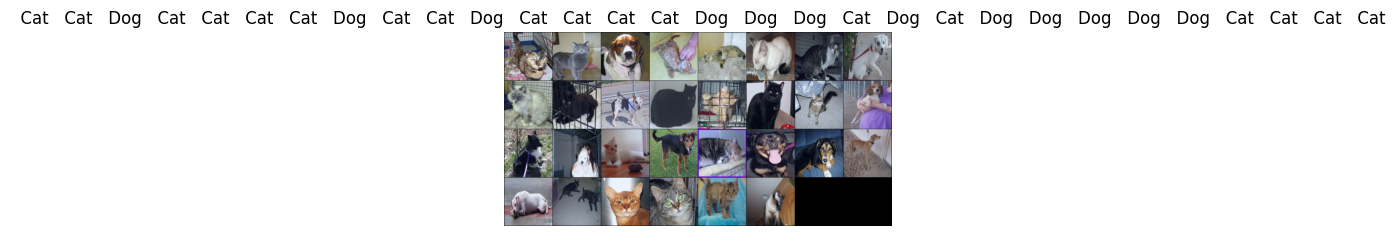

In [21]:
classes = ["Cat", "Dog"]

images, labels = iter(test_loader).__next__()

outputs = model(images.cuda())

_, predicted = torch.max(outputs.data, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(5)))

title = (' '.join('%5s' % classes[labels[j]] for j in range(30)))
imshow(torchvision.utils.make_grid(images, normalize=True), title)